# 1. H&M Personalized Fashion Recommendations

## Problem Statement: Given the features and image of a product,finding the similar products for recommendations using weighted nearest neighbors.
### 1.1.1 we will be using features and image of the product.
### I will use only 10 points, then you can scale to over 100k

### 1.1.2 Text featurization. : IDF weighted word2vec of Title

In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from collections import Counter
import os.path
from sklearn.metrics import pairwise_distances
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
#improting data as a pandas dataframe
HM_data = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
HM_data=HM_data.head(10000)

In [3]:
#getting the shape of the data
print("Number of data-points in the data:" , HM_data.shape[0])
print("Number of features in the data :" , HM_data.shape[1])

Number of data-points in the data: 10000
Number of features in the data : 25


In [4]:
#getting the column names
print(HM_data.columns)

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')


In [5]:
# Getting product image path
images_path=[]
i=0
for p in HM_data['article_id'].tolist():
    path= '../input/h-and-m-personalized-fashion-recommendations/images/' + '0' + str(p)[:2] + '/'+ '0' + str(p) +'.jpg'

    if os.path.exists(path):
        i+=1
        images_path.append(path)
    else: images_path.append(None)
print(f'There is {i} article with corresponding image')
    

There is 9883 article with corresponding image


In [6]:
#taking only 6 features and 7th feature will be image url
HM_data['image_path']=images_path
HM_data = HM_data[['article_id', 'prod_name', 'colour_group_name', 'image_path',
             'product_type_name', 'product_group_name', 'detail_desc']]
#getting the shape of the data
print("Number of data-points in the data:" , HM_data.shape[0])
print("Number of features in the data :" , HM_data.shape[1])

Number of data-points in the data: 10000
Number of features in the data : 7


In [7]:
#getting the head of the data
HM_data.head(3)

,article_id,prod_name,colour_group_name,image_path,product_type_name,product_group_name,detail_desc
0,108775015,Strap top,Black,../input/h-and-m-personalized-fashion-recommen...,Vest top,Garment Upper body,Jersey top with narrow shoulder straps.
1,108775044,Strap top,White,../input/h-and-m-personalized-fashion-recommen...,Vest top,Garment Upper body,Jersey top with narrow shoulder straps.
2,108775051,Strap top (1),Off White,../input/h-and-m-personalized-fashion-recommen...,Vest top,Garment Upper body,Jersey top with narrow shoulder straps.


## 2.1 Missing data for various features.
### 2.1.1 Basic stats for the feature: product_type_name

In [8]:
print(HM_data['product_type_name'].describe())

count        10000
unique          93
top       Trousers
freq          1080
Name: product_type_name, dtype: object


## Observations:

* About 12% (11169/105542) of the products are Trousers.
* There are 131 unique product types.

In [9]:
#find the 10 most frequent product_type_names.
product_type_count = Counter(list(HM_data['product_type_name']))
product_type_count.most_common(10)

[('Trousers', 1080),
 ('Sweater', 789),
 ('T-shirt', 723),
 ('Dress', 500),
 ('Socks', 495),
 ('Underwear bottom', 449),
 ('Vest top', 434),
 ('Shorts', 368),
 ('Hoodie', 329),
 ('Shirt', 329)]

### 2.1.2 Basic stats for the feature: color

In [10]:
print(HM_data['colour_group_name'].describe())

count     10000
unique       49
top       Black
freq       2070
Name: colour_group_name, dtype: object


## Observations:

* we have 50 unique colors
* Over 20% of products are black in color

In [11]:
#find the 10 most frequent colors.
color_count = Counter(list(HM_data['colour_group_name']))
color_count.most_common(10)

[('Black', 2070),
 ('Dark Blue', 1361),
 ('White', 774),
 ('Light Pink', 553),
 ('Grey', 524),
 ('Dark Grey', 416),
 ('Dark Red', 338),
 ('Light Grey', 291),
 ('Red', 291),
 ('Blue', 284)]

### 2.1.3 Basic stats for the feature: detail_desc

In [12]:
print(HM_data['detail_desc'].describe())

count                                                  9944
unique                                                 3132
top       Sleeveless bodysuits in soft organic cotton je...
freq                                                     45
Name: detail_desc, dtype: object


## Observations

* Most of the products have a detail_desc.
* detail_desc are fairly descriptive of what the product is.
* We use detail_desc extensively in this notebook as they are short and informative.

## 2.2 Remove near duplicate items using detail_desc feature

In [13]:
print("Number of duplicates present in articles: {}".format(sum(HM_data.duplicated("detail_desc"))))

Number of duplicates present in articles: 6867


In [14]:
HM_data

,article_id,prod_name,colour_group_name,image_path,product_type_name,product_group_name,detail_desc
0,108775015,Strap top,Black,../input/h-and-m-personalized-fashion-recommen...,Vest top,Garment Upper body,Jersey top with narrow shoulder straps.
1,108775044,Strap top,White,../input/h-and-m-personalized-fashion-recommen...,Vest top,Garment Upper body,Jersey top with narrow shoulder straps.
2,108775051,Strap top (1),Off White,../input/h-and-m-personalized-fashion-recommen...,Vest top,Garment Upper body,Jersey top with narrow shoulder straps.
3,110065001,OP T-shirt (Idro),Black,../input/h-and-m-personalized-fashion-recommen...,Bra,Underwear,"Microfibre T-shirt bra with underwired, moulde..."
4,110065002,OP T-shirt (Idro),White,../input/h-and-m-personalized-fashion-recommen...,Bra,Underwear,"Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...
9995,537708002,SEAN CREW NECK DEAL,Light Grey,../input/h-and-m-personalized-fashion-recommen...,Sweater,Garment Upper body,"Top in light, printed sweatshirt fabric with r..."
9996,537722001,BEAR KNOT TERRY,Grey,../input/h-and-m-personalized-fashion-recommen...,Sweater,Garment Upper body,Top in sweatshirt fabric with a decorative kno...
9997,537722004,BEAR KNOT TERRY,Pink,../input/h-and-m-personalized-fashion-recommen...,Sweater,Garment Upper body,Top in sweatshirt fabric with a decorative kno...
9998,537732001,Dita dress,Light Beige,None,Underdress,Underwear,"Microfibre slip with narrow, adjustable should..."


In [15]:
#removing data-points with short-titles
HM_data_sorted = HM_data[HM_data['detail_desc'].apply(lambda x: len(str(x).split())>4)]
print("After removal of products with short description:", HM_data_sorted.shape[0])

After removal of products with short description: 9851


In [16]:
# Sort the whole data based on title (alphabetical order of detail_desc) 
HM_data_sorted.sort_values('detail_desc',inplace=True, ascending=False)

### 2.2.1 Removing duplicates with Text sorted

In [17]:
#getting the duplicates 
indices = []
for i,row in HM_data_sorted.iterrows():
    indices.append(i)
    
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = HM_data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
       
    previous_i = i
    a = HM_data['detail_desc'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:
        b = HM_data['detail_desc'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        #count is used to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(HM_data_sorted['article_id'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(HM_data_sorted['article_id'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break    

In [18]:
#removing duplicated
HM_data = HM_data.loc[HM_data['article_id'].isin(stage1_dedupe_asins)]

In [19]:
#getting the number of data-points after removing the duplicates
print('Number of data points : ', HM_data.shape[0])

Number of data points :  3062


### 2.2.2 Removing duplicates which are not similar adjacently but very similar

In [20]:
indices = []
for i,row in HM_data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(HM_data['article_id'].loc[i])
    # consider the first apperal's title
    a = HM_data['detail_desc'].loc[i].split()
 
    for j in indices:
        
        b = HM_data['detail_desc'].loc[j].split()
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        #if the number of words in which both strings differ are < 3 ,
        #we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [21]:
#removing duplicate further
HM_data = HM_data.loc[HM_data['article_id'].isin(stage2_dedupe_asins)]

## 3. Text-PreProcessing:

In [22]:
#getting the number of data-points after removing all the duplicates
print('Number of data points after stage two of dedupe: ',HM_data.shape[0])

Number of data points after stage two of dedupe:  2971


In [23]:
HM_data

,article_id,prod_name,colour_group_name,image_path,product_type_name,product_group_name,detail_desc
0,108775015,Strap top,Black,../input/h-and-m-personalized-fashion-recommen...,Vest top,Garment Upper body,Jersey top with narrow shoulder straps.
3,110065001,OP T-shirt (Idro),Black,../input/h-and-m-personalized-fashion-recommen...,Bra,Underwear,"Microfibre T-shirt bra with underwired, moulde..."
7,111565003,20 den 1p Stockings,Beige,../input/h-and-m-personalized-fashion-recommen...,Socks,Socks & Tights,"Semi shiny nylon stockings with a wide, reinfo..."
8,111586001,Shape Up 30 den 1p Tights,Black,../input/h-and-m-personalized-fashion-recommen...,Leggings/Tights,Garment Lower body,Tights with built-in support to lift the botto...
9,111593001,Support 40 den 1p Tights,Black,../input/h-and-m-personalized-fashion-recommen...,Underwear Tights,Socks & Tights,"Semi shiny tights that shape the tummy, thighs..."
...,...,...,...,...,...,...,...
9985,537672001,Halloween Tattoos,Other Red,../input/h-and-m-personalized-fashion-recommen...,Fine cosmetics,Cosmetic,Temporary tattoos in different sizes.
9992,537688014,Rachel,Dark Grey,../input/h-and-m-personalized-fashion-recommen...,Sweater,Garment Upper body,Long polo-neck jumper in a soft knit with long...
9994,537691001,FRIDA furry jkt,Black,../input/h-and-m-personalized-fashion-recommen...,Jacket,Garment Upper body,"Jacket in soft faux fur with unlined sleeves, ..."
9997,537722004,BEAR KNOT TERRY,Pink,../input/h-and-m-personalized-fashion-recommen...,Sweater,Garment Upper body,Top in sweatshirt fabric with a decorative kno...


In [24]:
# removing stop-words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Convert all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        HM_data[column][index] = string
        
        
# we take each title and we text-preprocess it.
for index, row in HM_data.iterrows():
    nlp_preprocessing(row['detail_desc'], index, 'detail_desc') 

list of stop words: {'too', 'between', "isn't", 'theirs', 'few', 'an', "hadn't", 'll', 'to', 'are', 'over', 'hasn', 'am', "doesn't", 'were', 'didn', 'doesn', 'aren', 'shan', 'haven', 'shouldn', 'o', 'just', 'any', 'no', "aren't", 'mustn', "won't", 'and', "you've", "weren't", "shouldn't", 'doing', 'her', 'ma', "mightn't", 'their', 'a', 'the', 'our', 'now', 'not', 'both', 'most', "hasn't", 'each', 'will', 'below', 'against', 'them', 'further', 'who', 'during', "didn't", "you'd", 'about', 'above', 'from', "she's", 'does', 'there', 'themselves', 'itself', 're', 'these', 'his', 'ourselves', 'been', 'other', 'down', 'wouldn', 'your', 'having', 'if', 'very', 'wasn', 'yourselves', "that'll", 'while', 'd', 'once', 'this', "wouldn't", 'its', "you'll", 'which', 'only', 'don', "shan't", 'where', 'is', 'himself', 'or', 'has', 'again', 's', 'she', 've', 'how', 'into', 'such', 'y', 'isn', 'in', 'we', 'i', 'him', 'some', 'you', 'weren', "couldn't", 'those', "needn't", 'before', 'do', 'so', 'being', 'y

# Stemming

In [25]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))
# stemming doesn't convert the tokens into meaningful words 

argu
fish


In [26]:
# function to display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    #response = requests.get(url)
    img = Image.open(url)
    # we will display it in notebook 
    plt.imshow(img)

# function to generate the heatmap
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url
        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(list of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)       
        # displays combine figure ( heat map and image together)
        plt.show()

# function to display heatmap and image        
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf
    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]  
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys, values, labels, url, text)

#function to convert text into vector
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}

# function to display the result
def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)
    # vector2 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# 5.1 Bag of Words (BoW) on product detail_desc

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(HM_data['detail_desc'])
title_features.get_shape()
# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

(2971, 1582)

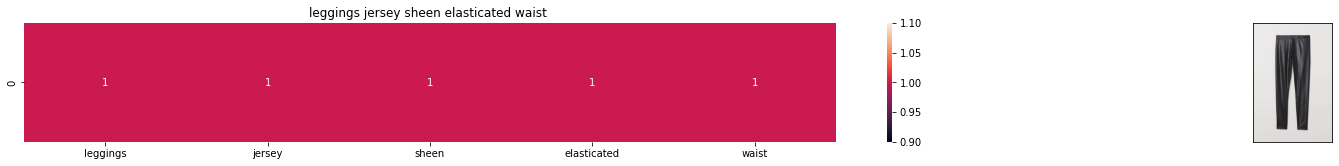

article_id : 506110001
detail_desc: leggings jersey sheen elasticated waist 
Euclidean similarity with the query image : 0.0


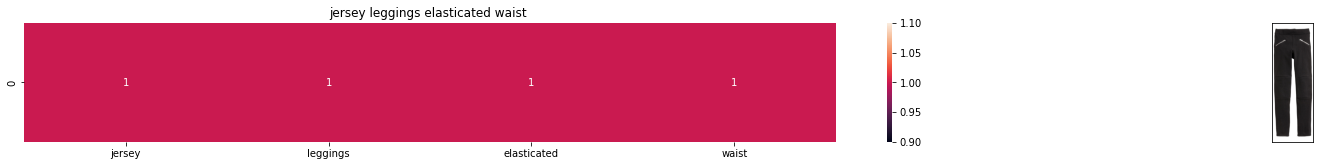

article_id : 537461001
detail_desc: jersey leggings elasticated waist 
Euclidean similarity with the query image : 1.0


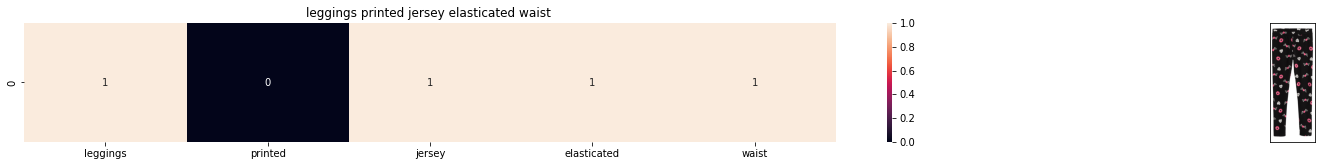

article_id : 507755004
detail_desc: leggings printed jersey elasticated waist 
Euclidean similarity with the query image : 1.4142135623730951


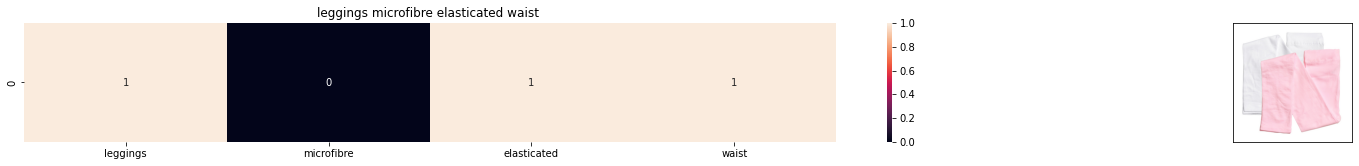

article_id : 500373003
detail_desc: leggings microfibre elasticated waist 
Euclidean similarity with the query image : 1.7320508075688772


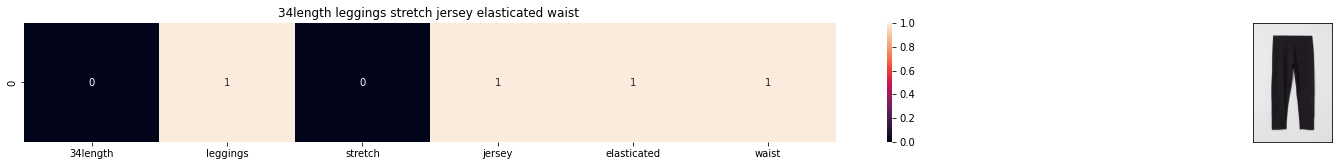

article_id : 129085001
detail_desc: 34length leggings stretch jersey elasticated waist 
Euclidean similarity with the query image : 1.7320508075688772


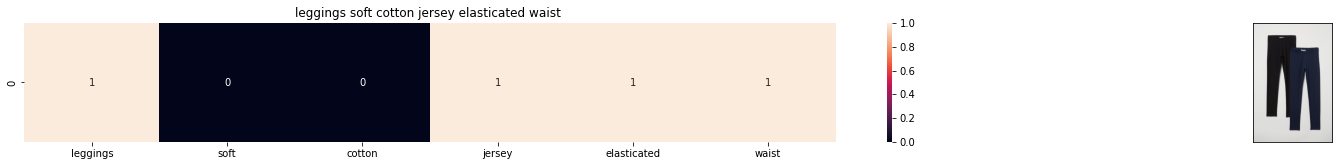

article_id : 306847010
detail_desc: leggings soft cotton jersey elasticated waist 
Euclidean similarity with the query image : 1.7320508075688772


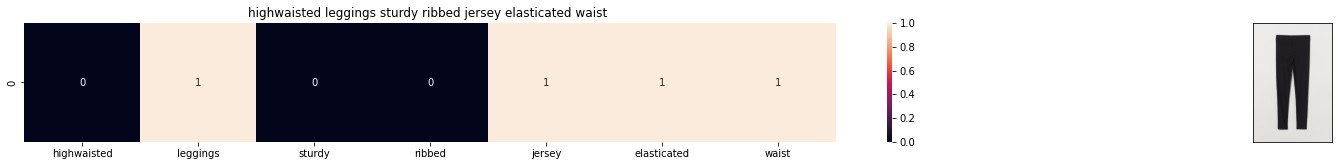

article_id : 243613004
detail_desc: highwaisted leggings sturdy ribbed jersey elasticated waist 
Euclidean similarity with the query image : 2.0


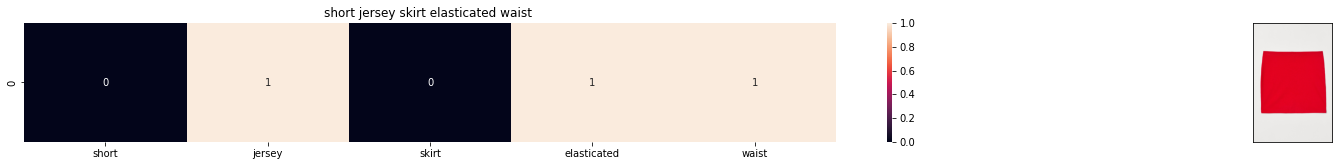

article_id : 189654046
detail_desc: short jersey skirt elasticated waist 
Euclidean similarity with the query image : 2.0


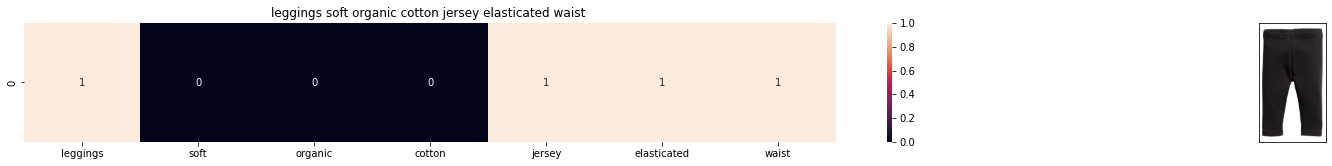

article_id : 240840032
detail_desc: leggings soft organic cotton jersey elasticated waist 
Euclidean similarity with the query image : 2.0


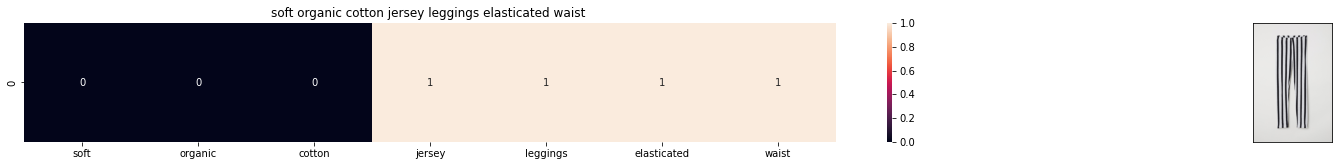

article_id : 194242050
detail_desc: soft organic cotton jersey leggings elasticated waist 
Euclidean similarity with the query image : 2.0


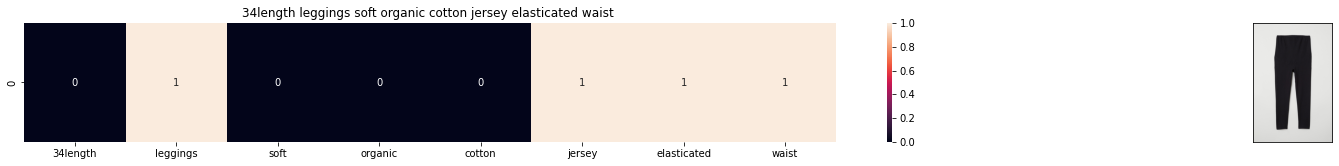

article_id : 198714001
detail_desc: 34length leggings soft organic cotton jersey elasticated waist 
Euclidean similarity with the query image : 2.23606797749979


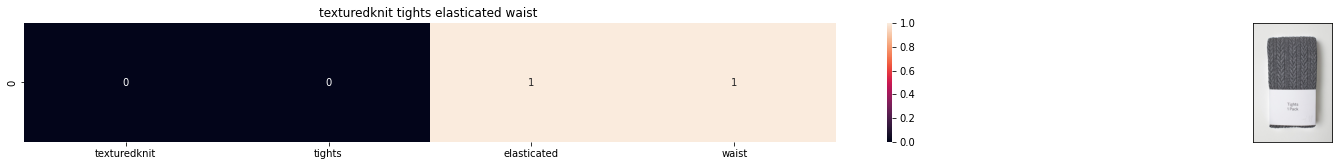

article_id : 297078002
detail_desc: texturedknit tights elasticated waist 
Euclidean similarity with the query image : 2.23606797749979


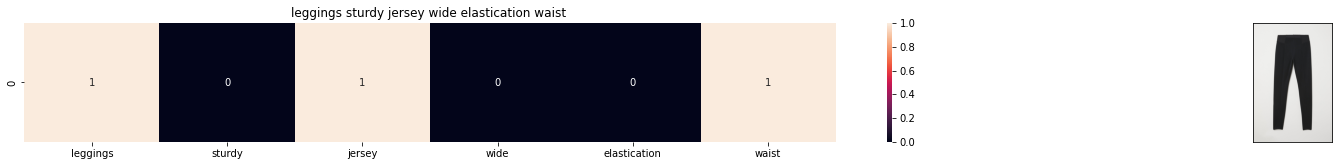

article_id : 457892005
detail_desc: leggings sturdy jersey wide elastication waist 
Euclidean similarity with the query image : 2.23606797749979


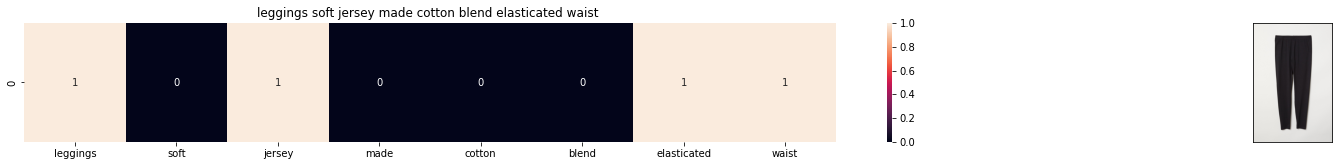

article_id : 368979001
detail_desc: leggings soft jersey made cotton blend elasticated waist 
Euclidean similarity with the query image : 2.23606797749979


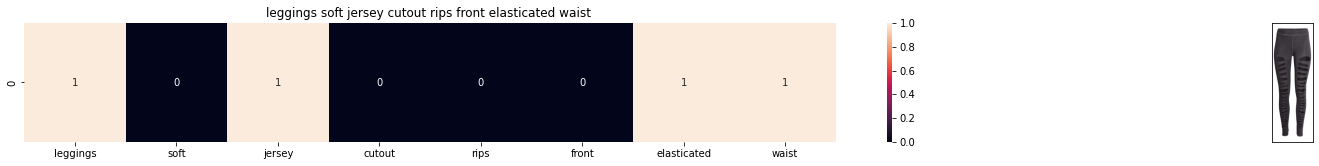

article_id : 495161001
detail_desc: leggings soft jersey cutout rips front elasticated waist 
Euclidean similarity with the query image : 2.23606797749979


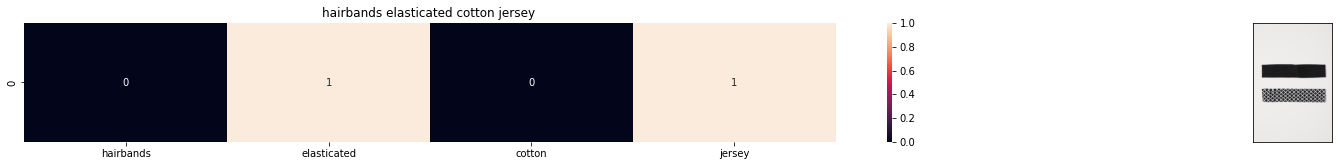

article_id : 478298012
detail_desc: hairbands elasticated cotton jersey 
Euclidean similarity with the query image : 2.23606797749979


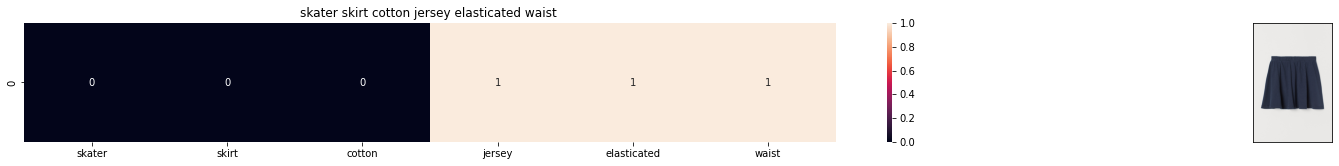

article_id : 317812011
detail_desc: skater skirt cotton jersey elasticated waist 
Euclidean similarity with the query image : 2.23606797749979


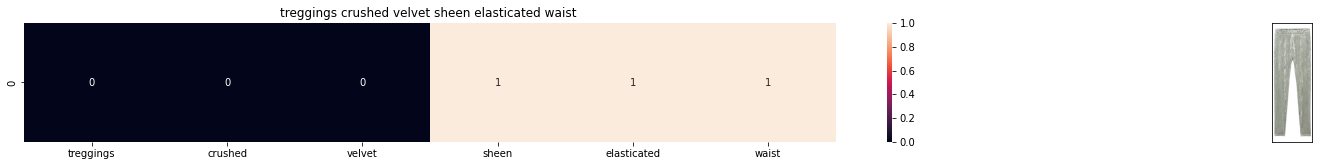

article_id : 431034005
detail_desc: treggings crushed velvet sheen elasticated waist 
Euclidean similarity with the query image : 2.23606797749979


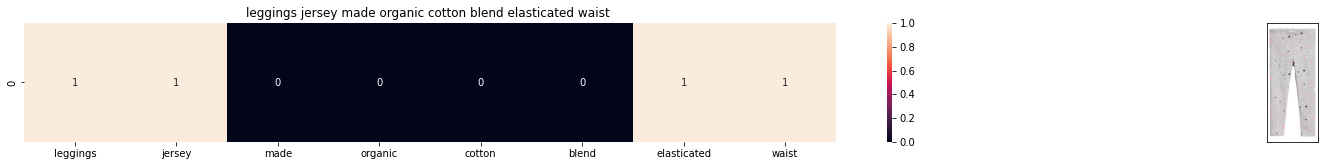

article_id : 478566026
detail_desc: leggings jersey made organic cotton blend elasticated waist 
Euclidean similarity with the query image : 2.23606797749979


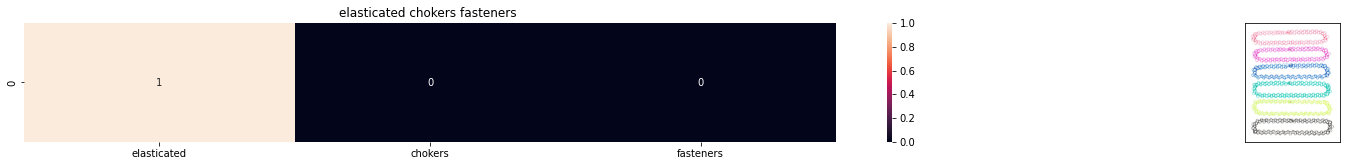

article_id : 529551001
detail_desc: elasticated chokers fasteners 
Euclidean similarity with the query image : 2.449489742783178


In [28]:
data=HM_data.copy()
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['detail_desc'].loc[df_indices[0]], data['detail_desc'].loc[df_indices[i]], data['image_path'].loc[df_indices[i]], 'bag_of_words')
        print('article_id :',data['article_id'].loc[df_indices[i]])
        print ('detail_desc:', data['detail_desc'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
#call the bag-of-words model for a product to get similar products
bag_of_words_model(1582, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title


# TF-IDF based product similarity

In [29]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['detail_desc'])

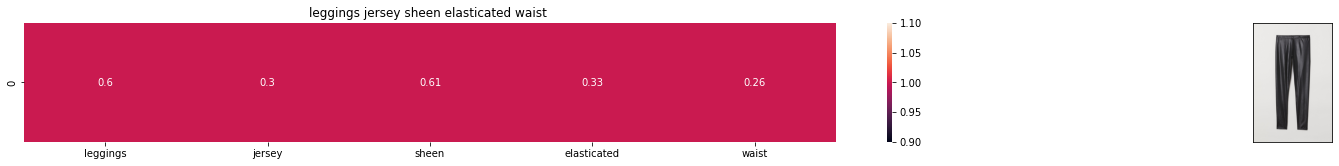

article_id : 506110001
Eucliden distance from the given image : 0.0


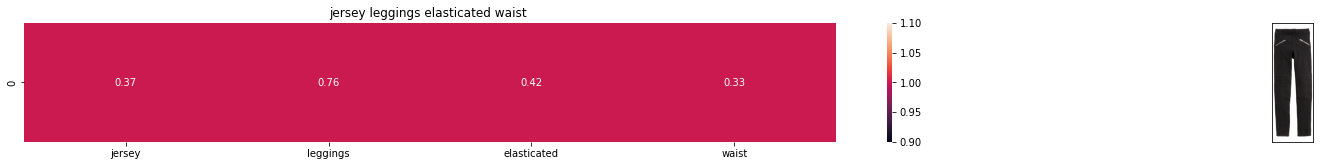

article_id : 537461001
Eucliden distance from the given image : 0.6435415655735828


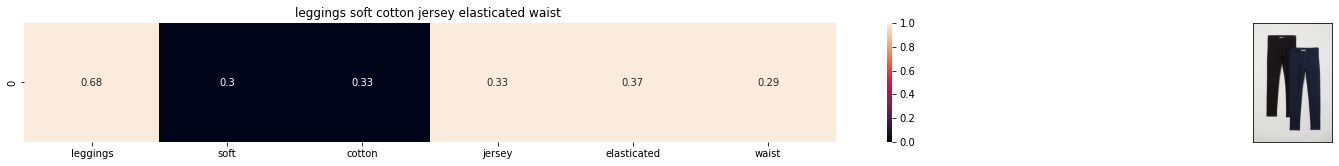

article_id : 306847010
Eucliden distance from the given image : 0.7621107452006506


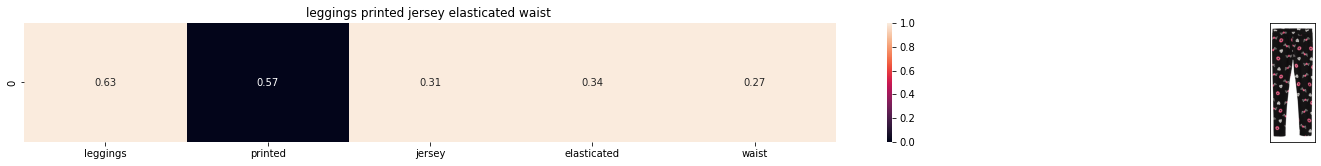

article_id : 507755004
Eucliden distance from the given image : 0.8348732545255494


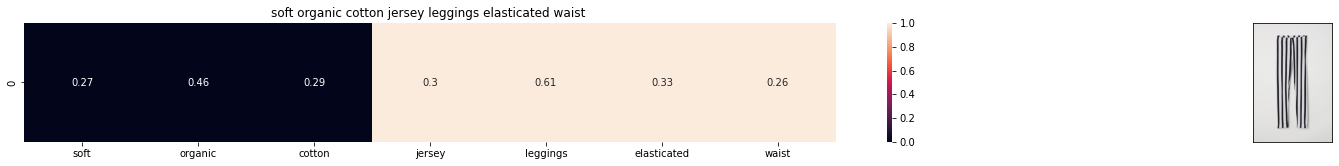

article_id : 194242050
Eucliden distance from the given image : 0.8594182366288856


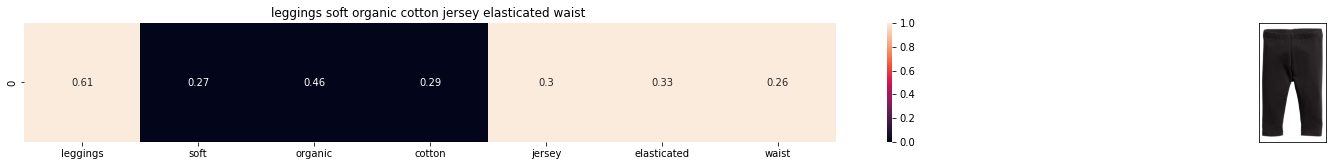

article_id : 240840032
Eucliden distance from the given image : 0.8594182366288856


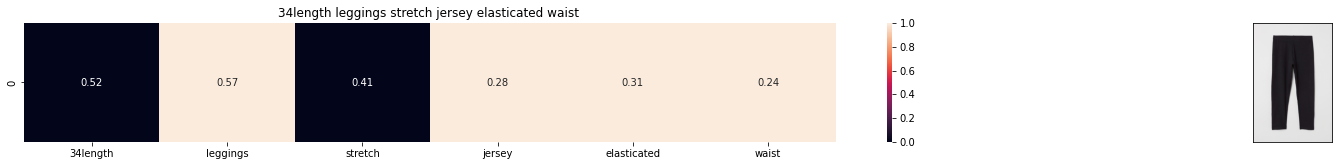

article_id : 129085001
Eucliden distance from the given image : 0.9032950392052735


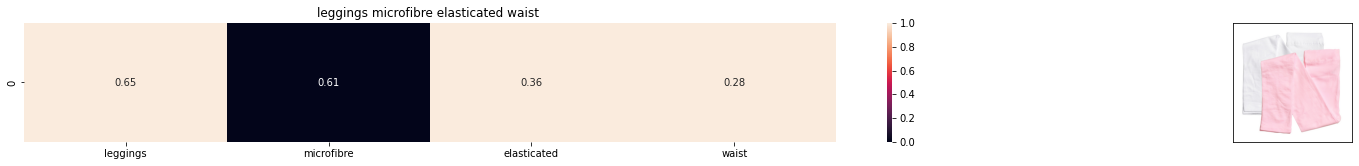

article_id : 500373003
Eucliden distance from the given image : 0.9125092962461371


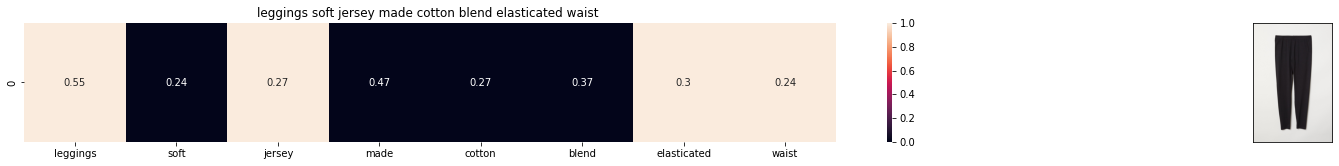

article_id : 368979001
Eucliden distance from the given image : 0.9267695468832922


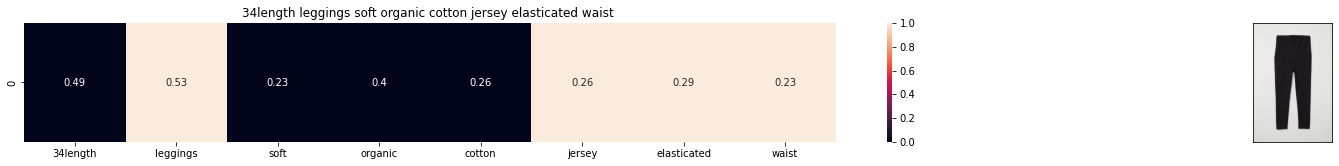

article_id : 198714001
Eucliden distance from the given image : 0.947661338302835


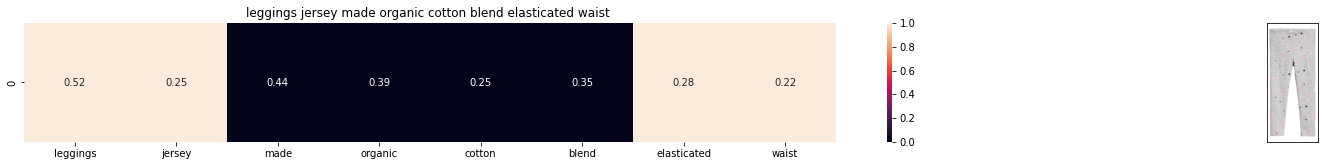

article_id : 478566026
Eucliden distance from the given image : 0.9584842604633832


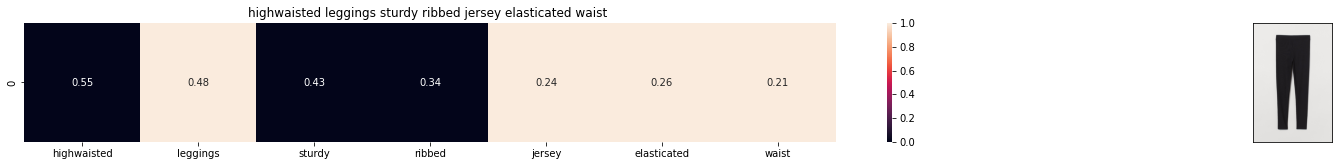

article_id : 243613004
Eucliden distance from the given image : 0.9979798360303731


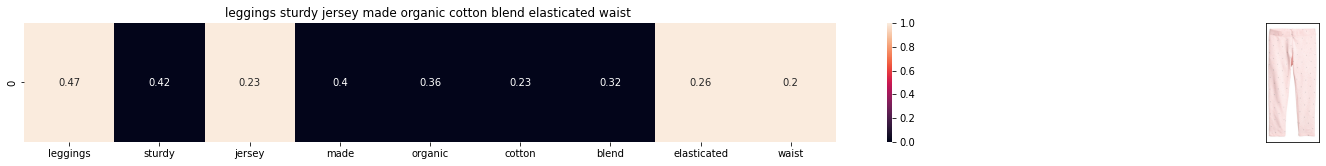

article_id : 508929048
Eucliden distance from the given image : 1.0088935133033574


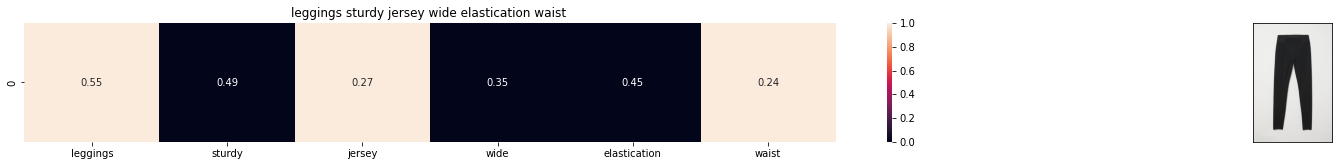

article_id : 457892005
Eucliden distance from the given image : 1.0238075461255796


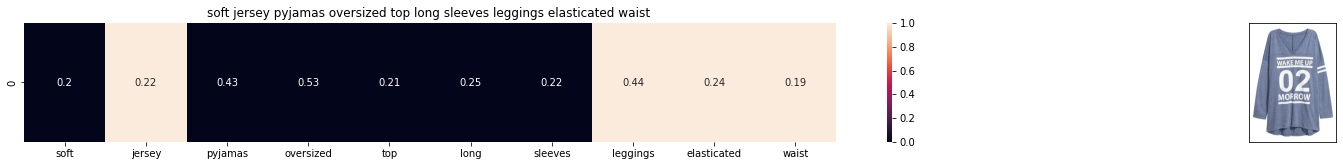

article_id : 536201001
Eucliden distance from the given image : 1.036591909965906


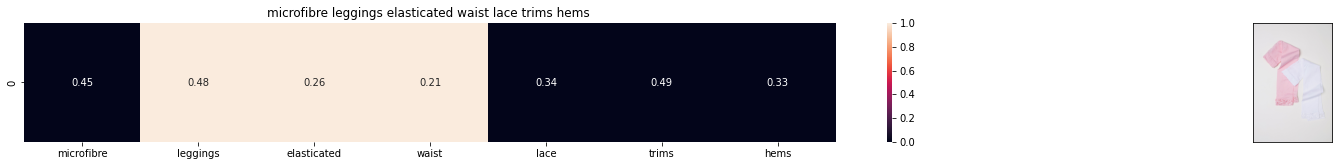

article_id : 343973011
Eucliden distance from the given image : 1.068415543766124


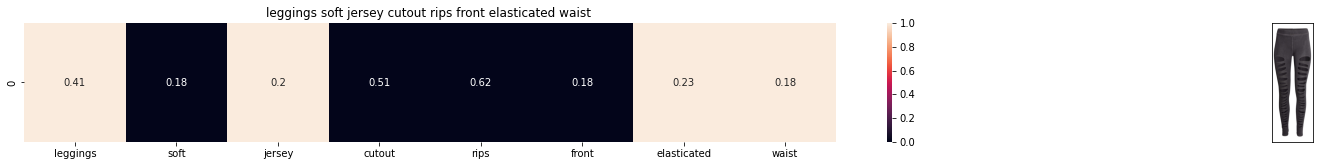

article_id : 495161001
Eucliden distance from the given image : 1.068748243700433


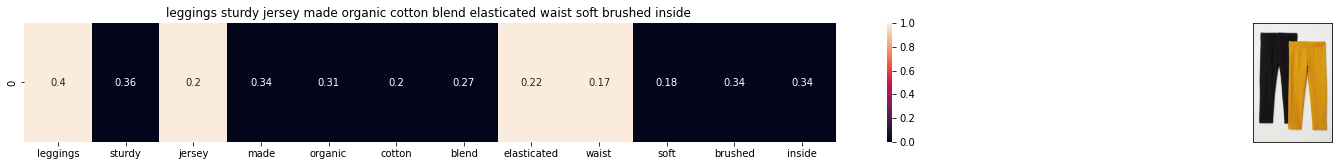

article_id : 516131006
Eucliden distance from the given image : 1.0759888578386805


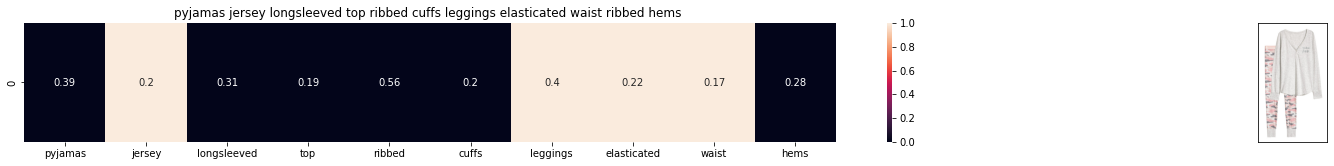

article_id : 235732026
Eucliden distance from the given image : 1.0772988415124405


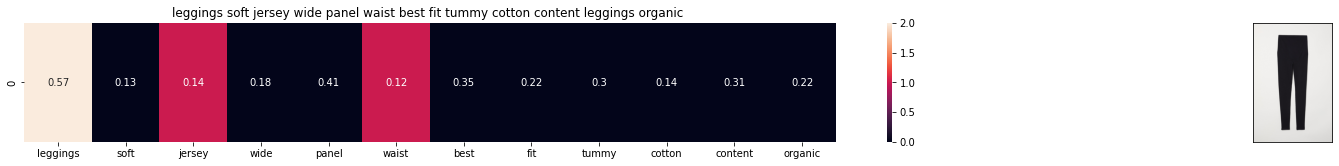

article_id : 120129001
Eucliden distance from the given image : 1.0780006999597502


In [30]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus  
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['detail_desc'].loc[df_indices[0]], data['detail_desc'].loc[df_indices[i]], data['image_path'].loc[df_indices[i]], 'tfidf')
        print('article_id :',data['article_id'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(1582, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

# IDF based product similarity

In [31]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['detail_desc'])

In [32]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['detail_desc'] if word in blob.split())
def idf(word):
    # idf = log(number of docs / number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [33]:
# converting the values into float
idf_title_features  = idf_title_features.astype(np.float)
for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    # to calculate idf_title_features we will replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i is present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:        
        # we will replace the count values of word i in document j with idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val  

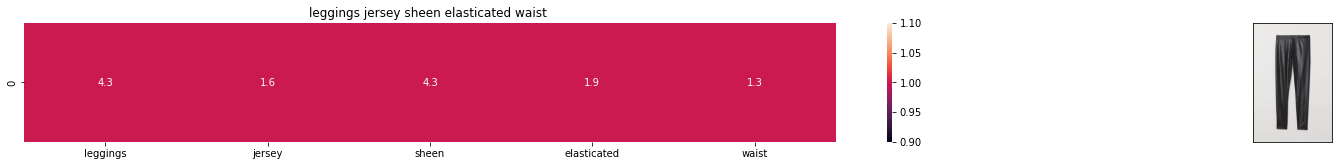

article_id : 506110001
euclidean distance from the given image : 0.0


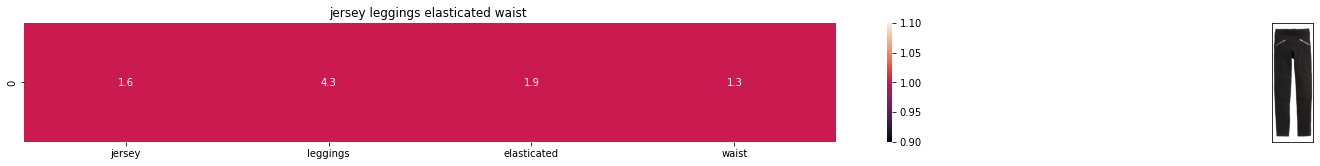

article_id : 537461001
euclidean distance from the given image : 4.333092229332961


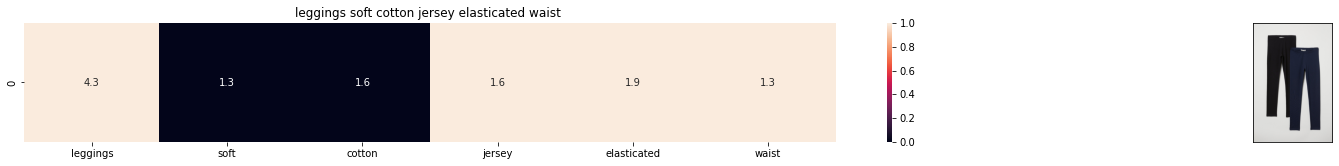

article_id : 306847010
euclidean distance from the given image : 4.78703642869475


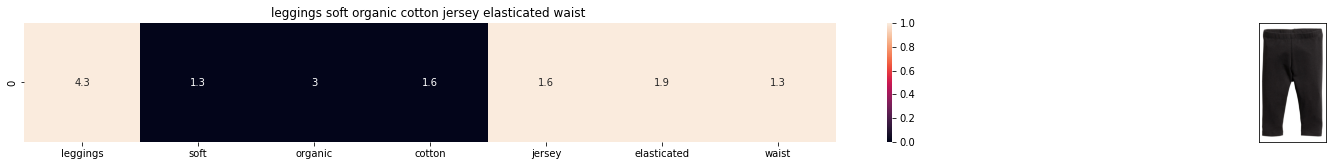

article_id : 240840032
euclidean distance from the given image : 5.6419876584334805


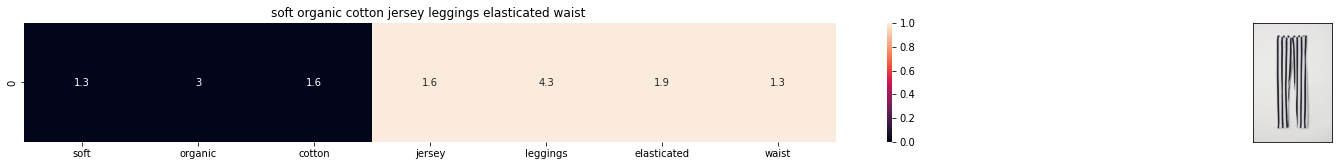

article_id : 194242050
euclidean distance from the given image : 5.6419876584334805


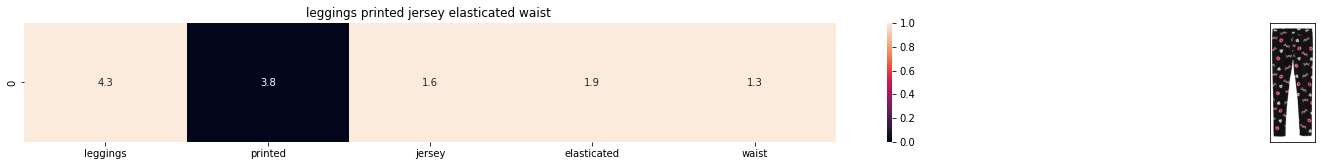

article_id : 507755004
euclidean distance from the given image : 5.767922561017054


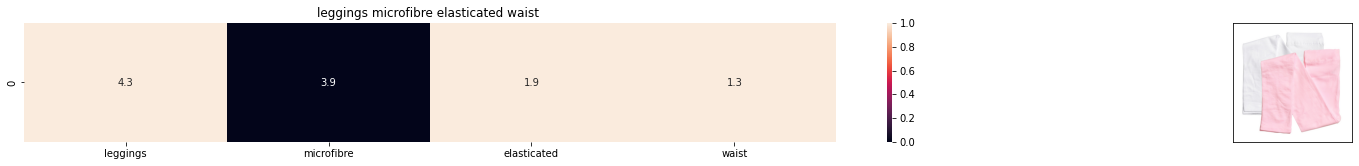

article_id : 500373003
euclidean distance from the given image : 6.06261475579142


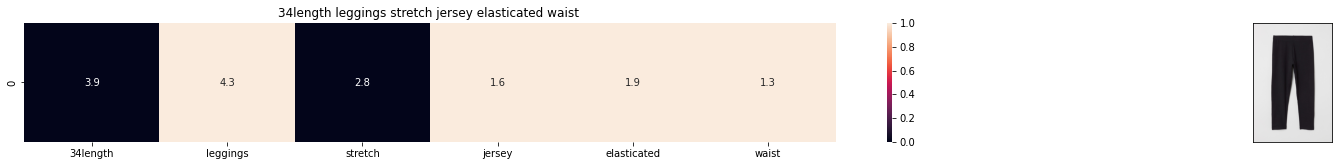

article_id : 129085001
euclidean distance from the given image : 6.4433908144051015


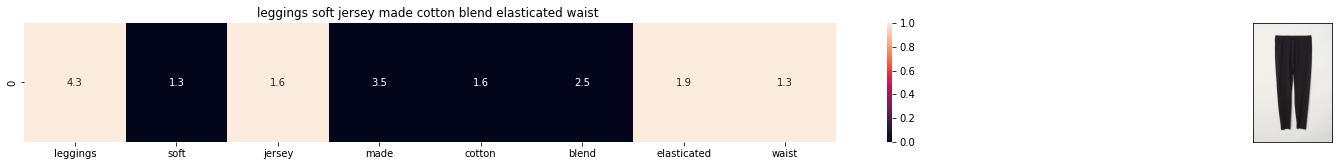

article_id : 368979001
euclidean distance from the given image : 6.446613436922598


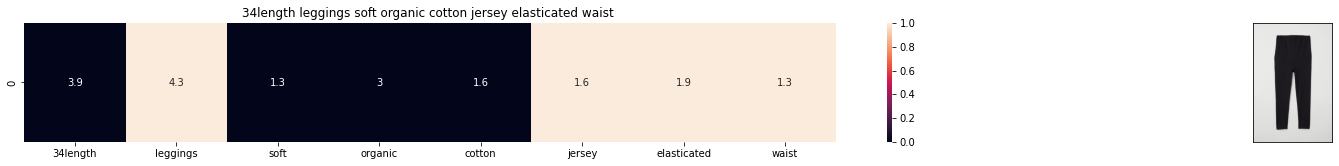

article_id : 198714001
euclidean distance from the given image : 6.8323959611671485


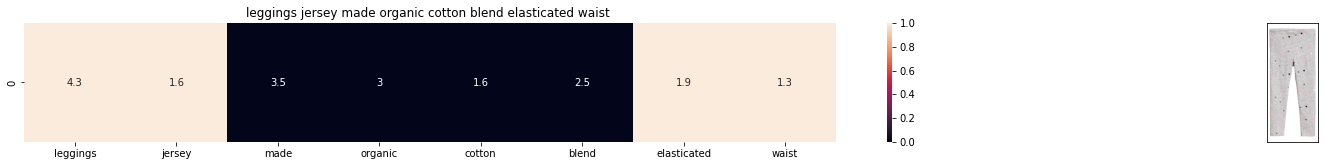

article_id : 478566026
euclidean distance from the given image : 6.981439587787805


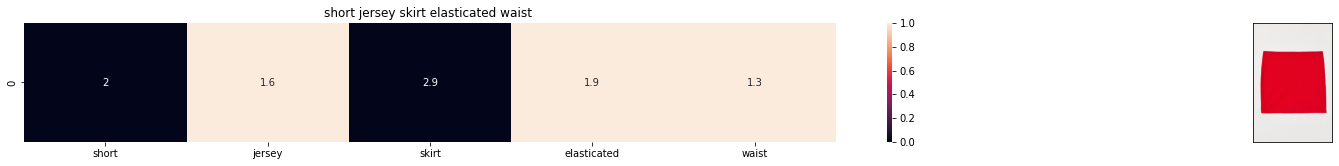

article_id : 189654046
euclidean distance from the given image : 7.041036937187074


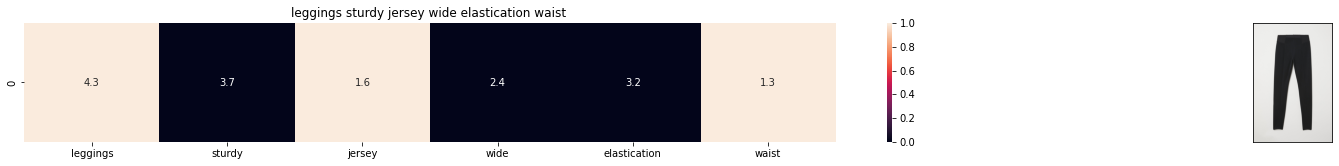

article_id : 457892005
euclidean distance from the given image : 7.208466694865336


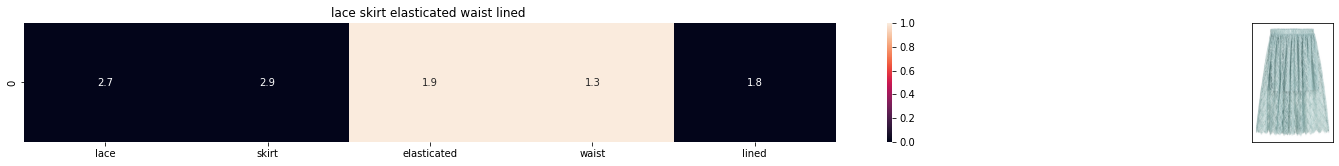

article_id : 510968001
euclidean distance from the given image : 7.661919237852069


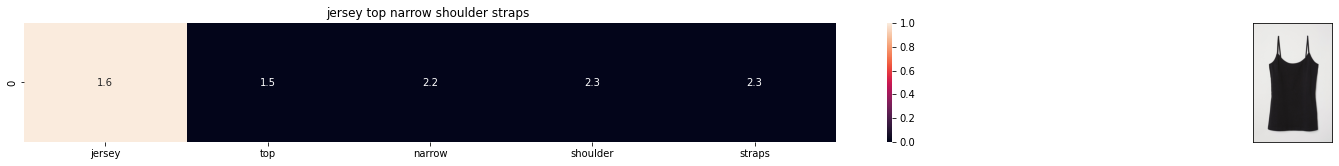

article_id : 108775015
euclidean distance from the given image : 7.725017315111633


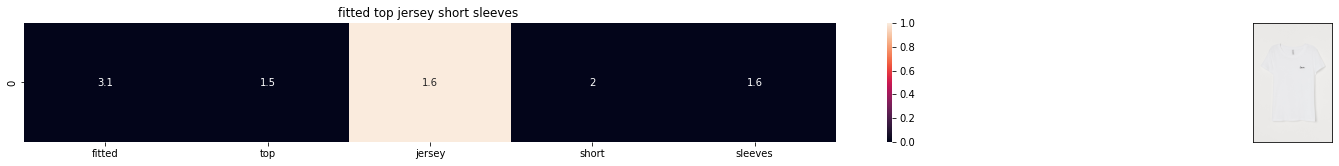

article_id : 306307002
euclidean distance from the given image : 7.766166175632602


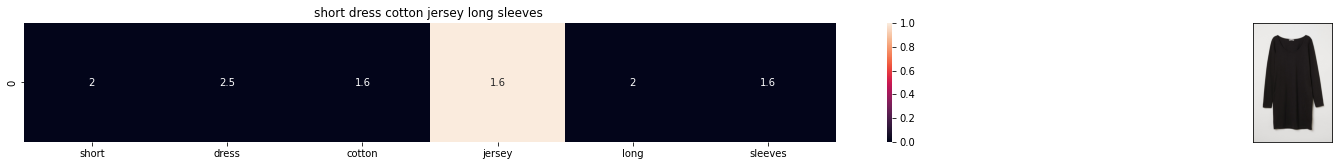

article_id : 502522001
euclidean distance from the given image : 7.842014217864008


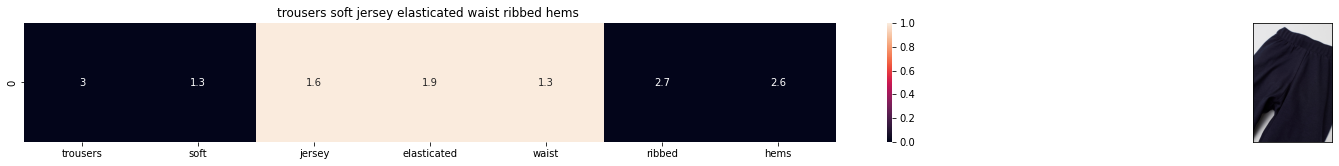

article_id : 377239007
euclidean distance from the given image : 7.851064195699097


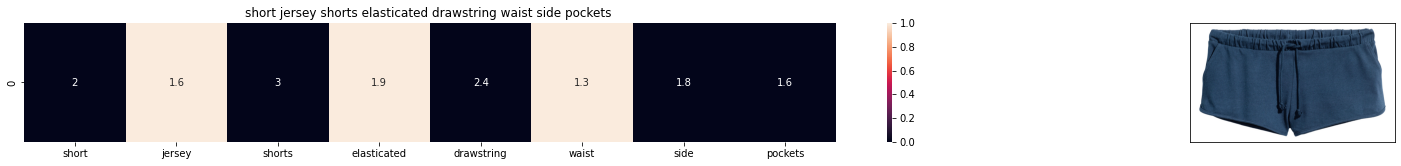

article_id : 477834005
euclidean distance from the given image : 7.8526517942058005


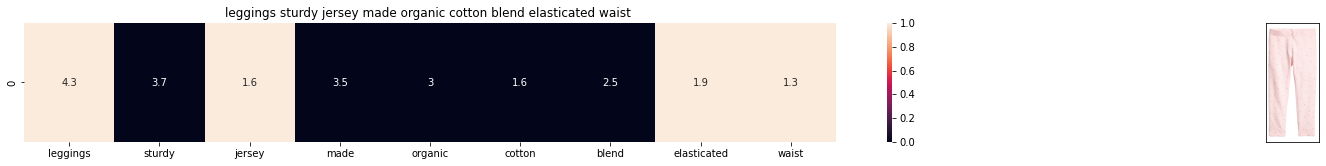

article_id : 508929048
euclidean distance from the given image : 7.891562546268101


In [34]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        get_result(indices[i],data['detail_desc'].loc[df_indices[0]], data['detail_desc'].loc[df_indices[i]], data['image_path'].loc[df_indices[i]], 'idf')
        print('article_id :',data['article_id'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)        
idf_model(1582,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title